# Bay Area Bike Share Analysis

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, I have performed an exploratory analysis on the data. I have performed two of the major parts of the data analysis process: data wrangling and exploratory data analysis. Before getting started, I asked myself some questions: if I were working for Bay Area Bike Share, what kinds of information I would want to know about in order to make smarter business decisions? If I were a user of the bike share service, what factors might influence how I would want to use the service?

**Questions can be answered by this analysis**:

Question 1 : What is the most attractive cities in Bay area for tourists? To answer this question, I explored the popularity of stations for the people with 3-day or 24-hour passes to pick up and return bikes. 

Question 2 : In which locations the Bike Share Company should add more stations and docks? For example, if we can infer from the data that most of the yearly subscribers use the bike to go to work, then the Bike Share Company should add more stations and docks in the area where more business and companies locate. Moreover, for the locations that attract the tourists most, the company should also consider to add more stations and docks.


> **Note**:<br /> 
(1) This block of text is written using [Markdown](http://daringfireball.net/projects/markdown/syntax), which is a way to format text using headers, links, italics, and many other options.<br />
(2) In 2014, Bay Area Bike Share held an [Open Data Challenge](http://www.bayareabikeshare.com/datachallenge-2014) to encourage data analysts to create visualizations based on their open data set. The winner of this challenge is Tyler Field ([link to Tyler's analysis](http://thfield.github.io/babs/index.html)).

## Data Wrangling

Now it's time to explore the data. The data is stored in the data folder. The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. I started by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below takes the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).


In [12]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [13]:
# file locations
file_in  = 'data/201402_trip_data.csv'
file_out = 'data/201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader) # datarow is a list of string, each string is an attribute for this record
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell reads in the sampled data file that created in the previous cell, and print out the first few rows of the table.

In [14]:
sample_data = pd.read_csv('data/201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, I concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. I also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. The below code cell shows how the station information is structured, then creates the station-city mapping. The station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function allows us to combine the station information across all three parts of our data when we are ready to explore everything.

In [15]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('data/201402_station_data.csv')
display(station_info.head())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Input: station_data is a list of file path;
    Output: create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data: 
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


We can use the mapping to condense the trip data. This is performed in the `summarise_data()` function below. As part of this function, the `datetime` module is used to **parse** the timestamp strings from the original data file as datetime objects (`strptime`), which can then be output in a different string format (`strftime`). The parsed objects also have a variety of attributes and methods to quickly obtain.


In [16]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments are lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.weekday()
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point) #write a dict each

In [17]:
# Process the data by running the function wrote above.
station_data = ['data/201402_station_data.csv']
trip_in = ['data/201309_trip_data.csv']
trip_out = 'data/201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,3,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,3,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,3,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,3,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,3,San Francisco,San Francisco,Subscriber


All counts are as expected!



## Exploratory Data Analysis

Next let's look at some initial trends in the data. 

In [19]:
trip_data = pd.read_csv('data/201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([ 6.81666667, 10.71666667, 17.28333333])

You should see that there are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration. In fact, the mean is larger than the 75% shortest durations. This implies there're some trips have very long duration.

Let's start looking at how those trips are divided by subscription type. 

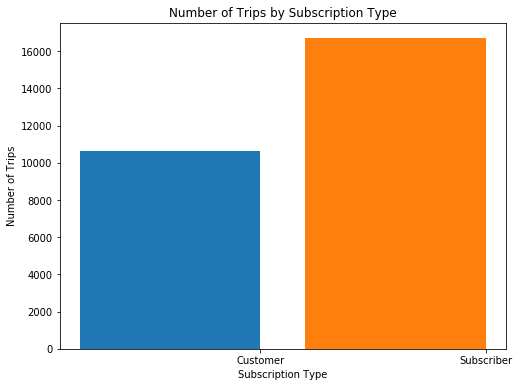

In [20]:
usage_plot(trip_data, 'subscription_type')

Looks like there's about 50% more trips made by subscribers in the first month than customers. What does the distribution of trip durations look like?

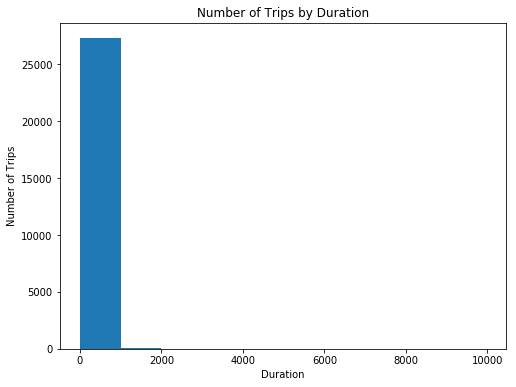

In [21]:
usage_plot(trip_data, 'duration')

Let's limit things to trips of less than 60 minutes.

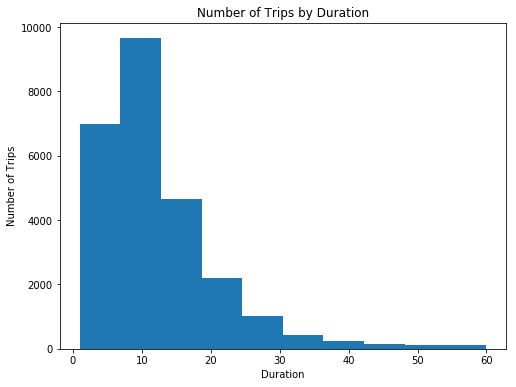

In [22]:
usage_plot(trip_data, 'duration', ['duration < 60'])

We can see that most trips are indeed less than 30 minutes in length. Since the minimum duration is not 0, the left hand bar is slighly above 0. As for the `usage_plot()` function, by setting "boundary" to 0, one of the bin edges (in this case the left-most bin) will start at 0 rather than the minimum trip duration. And by setting "bin_width" to 5, each bar will count up data points in five-minute intervals.

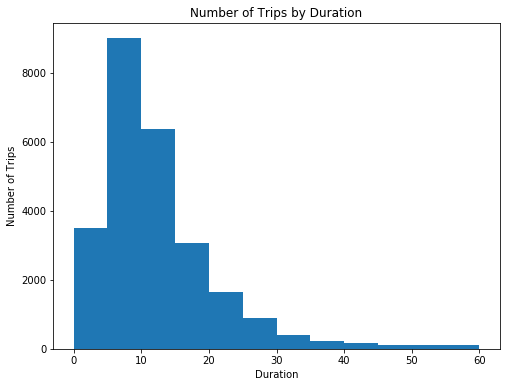

In [23]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

## Exploratory Analysis

Now it's time to put together all of the data in a single file and explore the trend. The code below will use the same `summarise_data()` function as before to process all data.

In [24]:
station_data = ['data/201402_station_data.csv',
                'data/201408_station_data.csv',
                'data/201508_station_data.csv' ]
trip_in = ['data/201402_trip_data.csv',
           'data/201408_trip_data.csv',
           'data/201508_trip_data.csv' ]
trip_out = 'data/babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

In [25]:
# Read-in the data
trip_data = pd.read_csv('data/babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,3,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,3,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,3,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,3,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,3,San Francisco,San Francisco,Subscriber


In [26]:
# Overall statistics
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([ 5.73333333,  8.61666667, 12.58333333])

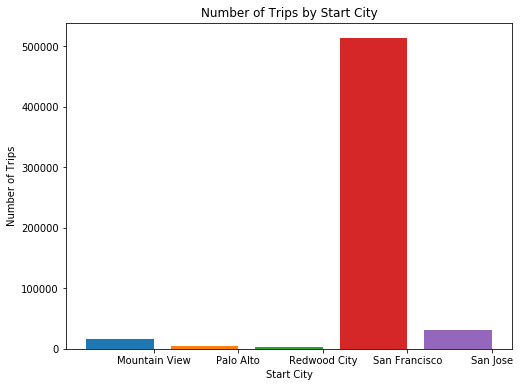

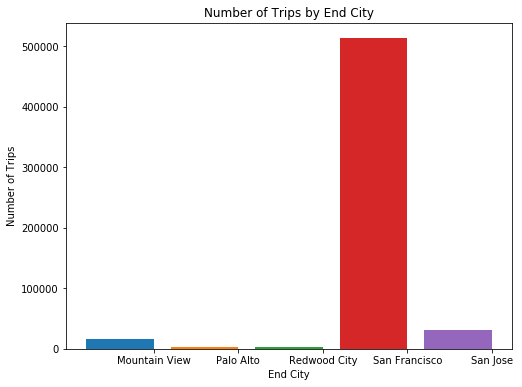

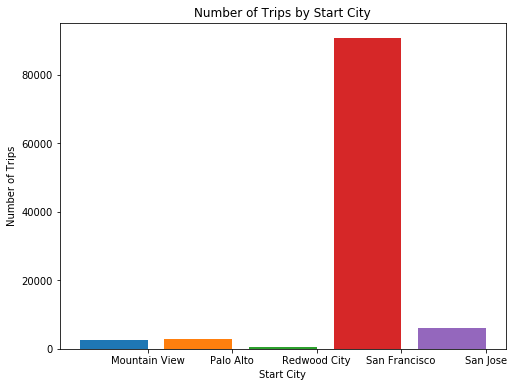

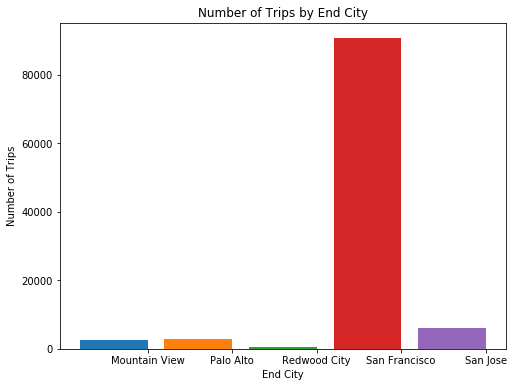

In [31]:
# Plot 1 -- Check the most popular city
usage_plot(trip_data,'start_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Subscriber'"])
usage_plot(trip_data,'start_city', ["subscription_type == 'Customer'"])
usage_plot(trip_data,'end_city', ["subscription_type == 'Customer'"])

From these visualiztions, I find SF is the most popular city for both tourists and commuters. It is easy to undertand that the tourists are most attracted to SF among all the cities. For the local people, they use the bike to go to work and head home. So it also makes sense that the stations in SF have more usage than those in other cities, because SF is a big city and has more business and residences. 

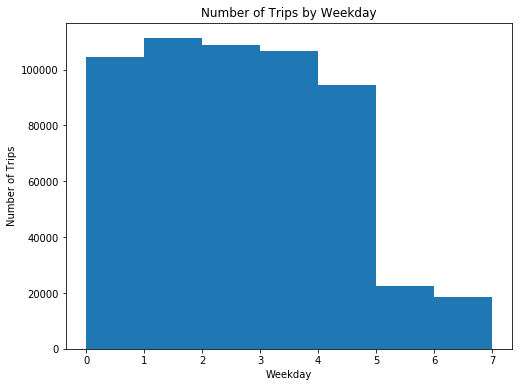

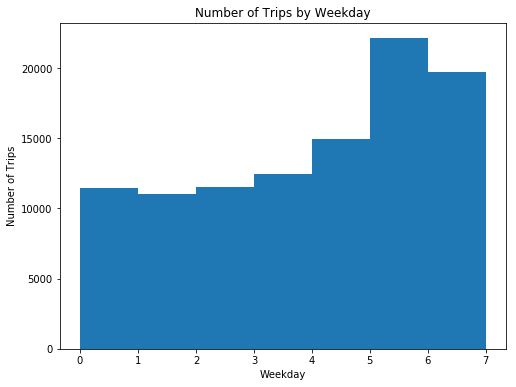

In [32]:
# Final Plot 2 -- Check the busiest day 
usage_plot(trip_data,'weekday', ["subscription_type == 'Subscriber'"],boundary = 0, bin_width = 1)
usage_plot(trip_data,'weekday', ["subscription_type == 'Customer'"], boundary = 0, bin_width = 1)

From these 2 visualizations, we can see that, for the subscribers, the usage of the bike in weekday is much more than that in weekend, which means the subscriber mainly use the bike to go to work. On the other hand, for the customers, they use the bikes more in the weekend. This could be explained as that people are more likely to travel in weekends.   

## Conclusions

This is only a taste of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, we might want to draw conclusions about the data by performing a statistical test or fitting the data to a model for making predictions. There are also a lot of potential analyses that could be performed. For example, instead of just looking at number of trips on the outcome axis, we could see what features affect things like trip duration. We also could look at how the weather data ties into bike usage.